In [2]:
import pandas as pd
import altair as alt
import numpy as np
import os
import sys

source_dir = '/Users/matthewdeverna/Documents/Projects/mean_field_quals/src'
sys.path.append(source_dir)


from simulations import run_simulation, get_peak_day, deriv_simple

### Testing with raw population counts

In [3]:
N = 1000
num_days = 100
step_size = 1  # step size
all_steps = np.arange(0, num_days, step_size)

### Set initial values ###
S_o = np.zeros(len(all_steps))
S_m = np.zeros(len(all_steps))
I_o = np.zeros(len(all_steps))
I_m = np.zeros(len(all_steps))
R_o = np.zeros(len(all_steps))
R_m = np.zeros(len(all_steps))

# These values are taking from the example found here (https://en.wikipedia.org/wiki/Compartmental_models_in_epidemiology#The_SIR_model_2)
# See the image on the side...
B_o = .4
beta_mult = 2 # This doesn't do anything because we assume ord_frac = 1
B_m = B_o * beta_mult
k = 0.04

S_o[0] = 997 # The rest are in the ordinary group
I_o[0] = 3   # Three people infected


In [4]:
t = 0

all_steps = np.arange(0, num_days, step_size)

for t in range(0, len(all_steps) - 1):
    
    d_s_o, d_i_o, d_r_o, d_s_m, d_i_m, d_r_m = deriv_simple(
        beta_o = B_o,
        beta_m = B_m,
        sus_o = S_o[t],
        sus_m = S_m[t],
        inf_o = I_o[t],
        inf_m = I_m[t],
        k = k,
        counts=True,
        N=N
    )

    # Set the next value as the current plus it's change
    S_o[t + 1] = S_o[t] + d_s_o
    S_m[t + 1] = S_m[t] + d_s_m
    I_o[t + 1] = I_o[t] + d_i_o
    I_m[t + 1] = I_m[t] + d_i_m
    R_o[t + 1] = R_o[t] + d_r_o
    R_m[t + 1] = R_m[t] + d_r_m

In [5]:
import matplotlib.pyplot as plt

In [6]:
I_o[-1] + S_o[-1] + R_o[-1]

1000.0000000000005

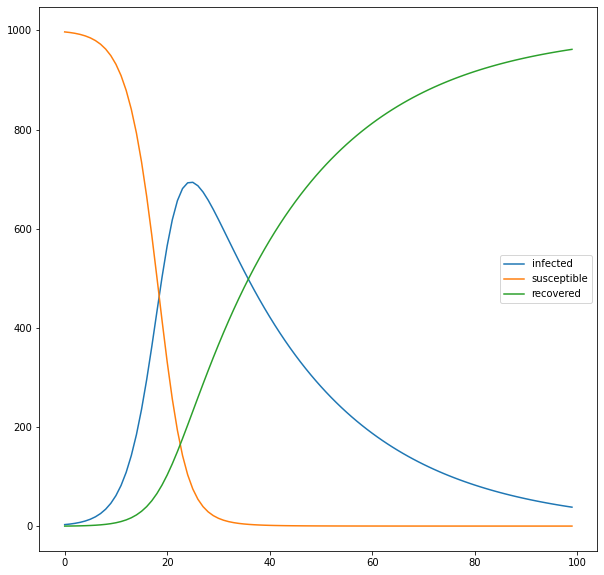

In [7]:
plt.figure(figsize=(10,10))

plt.plot(all_steps, I_o, label='infected')
plt.plot(all_steps, S_o, label='susceptible')
plt.plot(all_steps, R_o, label='recovered')

plt.legend()

# Varying $\beta$ with ordinary proportion $= x = 1$.

In [9]:
# Fraction of ordinary people
x = 1

# All beta values
beta_values = np.arange(.02, 1.02, .02)

# Less beta values highlighted for one of the later plots
less_betas = [0.2, 0.4, 0.6, 0.8, 1. ]

totals = []      # Total infections
r0s_ = []        # R0 valuyes
peak_days = []   # Date of each peak

# Will store the progression of infections over time, indexed by beta values
infection_flows = dict()


for beta in beta_values:
    
    # Run the simulation based on the input 
    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord=x,
        prop_infec=.001,
        num_days=100,
        beta_ord=beta,
        recovery_days=5,
        beta_mult=2,     # Multiple the current beta value by this to get the misinfo group beta
        w_homophily=False,
        alpha=None
    )
    total_ord_inf = max(R_o)
    
    if np.round(beta,2) in less_betas:

        infection_flows[np.round(beta,2)] = I_o
    
    r0s_.append( (r0s[0], beta) )
    
    totals.append((beta, total_ord_inf))

In [10]:
total_frame = pd.DataFrame(totals, columns = ['beta','total_infected'])

In [11]:
total_frame

,beta,total_infected
0,0.02,0.001111
1,0.04,0.001250
2,0.06,0.001428
3,0.08,0.001665
4,0.10,0.001997
5,0.12,0.002493
6,0.14,0.003310
7,0.16,0.004861
8,0.18,0.008428
9,0.20,0.018468


In [12]:
r0frames = pd.DataFrame(r0s_, columns=['r0', 'beta'])

In [13]:
beta_val = np.round(r0frames[r0frames['r0'] > 1]['beta'].min(), 2)

rule_text_df = pd.DataFrame({
    'x' : [r0frames[r0frames['r0'] > 1]['beta'].min()],
    'y1' : [0],
    'y2' : [3],
    'text' : [f"R0 > 1 (beta = {beta_val})"]
})

r0fig1 = alt.Chart(r0frames).mark_point(color='black', size=30).encode(
    x = alt.X(
        'beta:Q',
        axis = alt.Axis(
            title = None,
            labels = False,
            labelExpr="(datum.value*100) % 10 ? null : datum.label"
        )
    ),
    y = alt.Y(
        "r0:Q",
        title = "R0", axis=alt.Axis(orient='right')
    )
) + alt.Chart(rule_text_df).mark_rule(color = 'red').encode(
    x = 'x:Q',
    y = 'y1:Q',
    y2 = 'y2:Q'
) + alt.Chart(rule_text_df).mark_text(
    dx=10,
    dy=-10,
    fontSize=13
).encode(
    x = 'x:Q',
    y = 'y2:Q',
    text = 'text'
).properties(height=150, width=250)


rule_text_df = pd.DataFrame({
    'x' : [r0frames[r0frames['r0'] > 1]['beta'].min()],
    'y1' : [0],
    'y2' : [1],
    'text' : [f"R0 > 1 (beta = {beta_val})"]
})

tots_fig = alt.Chart(total_frame).mark_point(color='black', size=30).encode(
    x = alt.X(
        "beta:Q",
        axis = alt.Axis(
            title=['beta','(no misinformed population)'],
            labelExpr="(datum.value*100) % 10 ? null : datum.label"
        )
    ),
    y = alt.Y("total_infected:Q", title=['proportion of','population infected'], axis=alt.Axis(orient='right'))
) + alt.Chart(rule_text_df).mark_rule(color = 'red').encode(
    x = 'x:Q',
    y = 'y1:Q',
    y2 = 'y2:Q'
).properties(height=150, width=250)



combined_fig = alt.vconcat(r0fig1, tots_fig, spacing=5)

combined_fig

# .configure_axis(
#     titleFontSize=15,
#     labelFontSize=14,
#     labelAngle=0
# ).configure_legend(
#     titleFontSize=15,
#     labelFontSize=14,
# )

alt.VConcatChart(...)

In [12]:
infection_flows.keys()

dict_keys([0.2, 0.4, 0.6, 0.8, 1.0])

In [13]:
infections = pd.DataFrame(infection_flows).reset_index()
infections = infections.rename(columns={'index':'day'})
infections.day = infections.day +1
infections.melt(id_vars='day')

,day,variable,value
0,1,0.2,1.000000e-03
1,2,0.2,9.998000e-04
2,3,0.2,9.995601e-04
3,4,0.2,9.992803e-04
4,5,0.2,9.989607e-04
...,...,...,...
495,96,1.0,1.064079e-08
496,97,1.0,8.534438e-09
497,98,1.0,6.845038e-09
498,99,1.0,5.490057e-09


In [14]:
info = []

for beta, infects in infection_flows.items():
    peak_x = get_peak_day(infects)
    peak_y = max(infects)
    text = f"{np.round(peak_y,2)} (beta = {beta})"
    info.append( (peak_x, peak_y, text) )

In [15]:
text_dfs = pd.DataFrame(info, columns = ['peak_x', 'peak_y', 'text'])
text_dfs

,peak_x,peak_y,text
0,0,0.001000,0.0 (beta = 0.2)
1,36,0.161499,0.16 (beta = 0.4)
2,22,0.324923,0.32 (beta = 0.6)
3,16,0.447510,0.45 (beta = 0.8)
4,13,0.541865,0.54 (beta = 1.0)


In [16]:
text_dfs = text_dfs[text_dfs['peak_x']>0]


In [17]:
lines = alt.Chart(infections.melt(id_vars='day')).mark_line(size=2, color = 'black').encode(
    x = alt.X(
        'day:Q',
        title = ["Time", "(days)"]
    ),
    y = alt.Y(
        'value:Q',
        title = ["proportion of population infected", "(no misinformed group)"],
        scale = alt.Scale(domain=(0,1))
    ),
    strokeDash = alt.StrokeDash(
        'variable:N',
        title = "beta",
        legend=None
    )
).properties(height=320, width=500)

texts = alt.Chart(text_dfs).mark_text(dy=-7,dx=0,fontSize=14,align='left').encode(
    x = 'peak_x:Q',
    y = 'peak_y:Q',
    text = 'text'
)

lines = alt.layer(lines,texts)


alt.hconcat(
    lines,
    combined_fig,
).configure_axis(
    titleFontSize=15,
    labelFontSize=14,
    labelAngle=0
)
# .configure_legend(
#     titleFontSize=15,
#     labelFontSize=14,
#     orient='top',
#     offset=0
# )

alt.HConcatChart(...)

# How infections change based on recovery rate

In [18]:
# Fraction of ordinary people
x = 1

# All beta values
beta_values = np.arange(.1, 1.1, .1)

totals = []      # Total infections
r0s_ = []        # R0 valuyes
peak_days = []   # Date of each peak

# Will store the progression of infections over time, indexed by beta values
infection_flows = dict()

recovery_days = np.arange(1,21,1)

# We fix beta at .3 based on the above
beta= .3

for rec_days in recovery_days:

    # Run the simulation based on the input 
    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord=x,
        prop_infec=.001,
        num_days=100,
        beta_ord=beta,
        recovery_days=rec_days,
        beta_mult=2     # Multiple the current beta value by this to get the misinfo group beta
    )
    total_ord_inf = max(R_o)

    infection_flows[(rec_days)] = I_o

    r0s_.append( (r0s[0], rec_days) )

    totals.append((rec_days, total_ord_inf))

0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6
0.3 0.6


In [19]:
r0frames = pd.DataFrame(r0s_, columns=['r0', 'rec_days'])

In [20]:
infections = pd.DataFrame(infection_flows).reset_index()
infections = infections.rename(columns={'index':'day'})
infections.day = infections.day +1
infections.melt(id_vars='day')

,day,variable,value
0,1,1,0.001000
1,2,1,0.000300
2,3,1,0.000090
3,4,1,0.000027
4,5,1,0.000008
...,...,...,...
1995,96,20,0.040704
1996,97,20,0.038697
1997,98,20,0.036788
1998,99,20,0.034974


In [21]:
lines = alt.Chart(infections.melt(id_vars='day')).transform_filter(
    "datum.variable % 4 == 0"
).mark_line(size=2, color='black').encode(
    x = alt.X(
        'day:Q',
        title = ["time", "(days)"]
    ),
    y = alt.Y(
        'value:Q',
        title = ["proportion of population infected", "(no misinformed group)"],
#         scale = alt.Scale(domain=(0,1))
    ),
    strokeDash = alt.StrokeDash(
        'variable:N',
        title = "days to recover",
#         legend=None
    ) 
#     shape = alt.Shape(
#         'variable:N'
#     ),
#     color = alt.Color(
#         'variable:N',
#         legend = alt.Legend(title='days to recover')
#     )
).properties(width=500, height=320)
# .configure_axis(
#     titleFontSize=15,
#     labelFontSize=14,
#     labelAngle=0
# ).configure_legend(
#     titleFontSize=15,
#     labelFontSize=14,
# )

# texts = alt.Chart(text_dfs).mark_text(dy=-7,dx=10,fontSize=14).encode(
#     x = 'peak_x:Q',
#     y = 'peak_y:Q',
#     text = 'text'
# )

# alt.layer(lines,texts).configure_axis(
#     titleFontSize=15,
#     labelFontSize=14,
#     labelAngle=0
# ).configure_legend(
#     titleFontSize=15,
#     labelFontSize=14,
# )

lines

alt.Chart(...)

In [22]:
peak_days = []

for recovery_period, infections in infection_flows.items():
    
    peak_days.append( (recovery_period, get_peak_day(infections)) )

peaks_df = pd.DataFrame(peak_days, columns = ['recovery', 'peak_day'])
peaks_df

,recovery,peak_day
0,1,0
1,2,0
2,3,0
3,4,83
4,5,59
5,6,51
6,7,46
7,8,44
8,9,42
9,10,41


In [23]:
min_rec = r0frames[r0frames['r0'] > 1]['rec_days'].min()

rule_text_df = pd.DataFrame({
    'x' : [r0frames[r0frames['r0'] > 1]['rec_days'].min()],
    'y1' : [0],
    'y2' : [3.5],
    'text' : [f"R0 > 1 ({min_rec} days)"]
})

rnaught_fig = alt.Chart(r0frames).mark_point(color='black').encode(
    x = alt.X(
        "rec_days:Q",
        axis = alt.Axis(
            title=None,
            labels=False
        )
    ),
    y = alt.Y("r0:Q", title = "R0", axis=alt.Axis(orient='right')),
) + alt.Chart(rule_text_df).mark_text(
    dx=0,
    dy=-10,
    fontSize=13
).encode(
    x = 'x:Q',
    y = 'y2:Q',
    text = 'text'
) + alt.Chart(rule_text_df).mark_rule(color = 'red').encode(
    x = 'x:Q',
    y = 'y1:Q',
    y2 = 'y2:Q'
).properties(height=150, width=250)
    


rule_text_df = pd.DataFrame({
    'x' : [r0frames[r0frames['r0'] > 1]['rec_days'].min()],
    'y1' : [0],
    'y2' : [90],
    'text' : [f"R0 > 1 ({min_rec} days)"]
})

peaks_fig = alt.Chart(peaks_df).mark_point(color='black').encode(
    x = alt.X("recovery:Q", title =['days to recover']),
    y = alt.Y("peak_day:Q", title = "peak infection day", axis=alt.Axis(orient='right')),
) + alt.Chart(rule_text_df).mark_rule(color = 'red').encode(
    x = 'x:Q',
    y = 'y1:Q',
    y2 = 'y2:Q'
).properties(height=150, width=250)



alt.hconcat(
    lines, 
    alt.vconcat(rnaught_fig,peaks_fig, spacing=5),
).configure_axis(
    titleFontSize=15,
    labelFontSize=14,
    labelAngle=0
).configure_legend(
    titleFontSize=15,
    labelFontSize=14,
    orient='top',
    offset=0
)

alt.HConcatChart(...)

### In the above, we fix beta at 0.3

In [24]:
r0frames

,r0,rec_days
0,0.3,1
1,0.6,2
2,0.9,3
3,1.2,4
4,1.5,5
5,1.8,6
6,2.1,7
7,2.4,8
8,2.7,9
9,3.0,10


### Varying $\beta$ with half misinformed and half ordinary. Again, we fix beta at 0.3

In [163]:
# Fraction of ordinary people
x = .5

# All beta values
beta_values = np.arange(.1, 1.1, .1)

totals = []      # Total infections
r0s_ = []        # R0 valuyes
peak_days = []   # Date of each peak

# Will store the progression of infections over time, indexed by beta values
infection_flows_ord = dict()
infection_flows_mis = dict()

recovery_days = np.arange(1,21,1)

# We fix beta at .3 and recovery at 7 days based on the above
beta = .3
rec_days = 7

# multipliers = [1.2, 1.4, 1.6, 1.8, 2, 4, 6]
multipliers = np.arange(1,6.5,.5)

for multiplier in multipliers:

    # Run the simulation based on the input 
    S_o, S_m, I_o, I_m, R_o, R_m, r0s = run_simulation(
        frac_ord=x,
        prop_infec=.001,
        num_days=100,
        beta_ord=beta,
        recovery_days=rec_days,
        beta_mult=multiplier
    )
    total_ord_inf = max(R_o)
    total_mis_inf = max(R_m)

    infection_flows_ord[multiplier] = I_o
    infection_flows_mis[multiplier] = I_m
    
    # ord_r0, mis_r0, weighted_avg_r0
    r0s_.append( (r0s[0], r0s[1], r0s[2], multiplier) )

    totals.append((total_ord_inf, total_mis_inf, multiplier))

0.3 0.3
0.3 0.44999999999999996
0.3 0.6
0.3 0.75
0.3 0.8999999999999999
0.3 1
0.3 1
0.3 1
0.3 1
0.3 1
0.3 1


In [164]:
r0frames = pd.DataFrame(r0s_, columns = ['ordinary', 'misinfo', 'weighted_avg', 'multiplier'])

In [165]:
r0frames

,ordinary,misinfo,weighted_avg,multiplier
0,2.1,2.10,2.100,1.0
1,2.1,3.15,2.625,1.5
2,2.1,4.20,3.150,2.0
3,2.1,5.25,3.675,2.5
4,2.1,6.30,4.200,3.0
5,2.1,7.00,4.550,3.5
6,2.1,7.00,4.550,4.0
7,2.1,7.00,4.550,4.5
8,2.1,7.00,4.550,5.0
9,2.1,7.00,4.550,5.5


In [166]:
alt.Chart(r0frames.melt(id_vars='multiplier')).mark_point().encode(
    x = alt.X('multiplier:Q'),
    y = alt.Y('value:Q'),
    color = alt.Color('variable:N')
)

alt.Chart(...)

In [185]:
both_totals = pd.DataFrame(totals, columns = ['total_ord_inf', 'total_mis_inf', 'multiplier'])
both_totals['diff'] = both_totals['total_mis_inf'] - both_totals['total_ord_inf']
both_totals['total_inf'] = both_totals['total_ord_inf'] + both_totals['total_mis_inf'] 

both_totals

,total_ord_inf,total_mis_inf,multiplier,diff,total_inf
0,0.413049,0.413223,1.0,0.000174,0.826272
1,0.428258,0.473931,1.5,0.045673,0.902189
2,0.432530,0.492085,2.0,0.059555,0.924615
3,0.434127,0.497691,2.5,0.063563,0.931818
4,0.434855,0.499372,3.0,0.064517,0.934227
5,0.435146,0.499750,3.5,0.064604,0.934895
6,0.435146,0.499750,4.0,0.064604,0.934895
7,0.435146,0.499750,4.5,0.064604,0.934895
8,0.435146,0.499750,5.0,0.064604,0.934895
9,0.435146,0.499750,5.5,0.064604,0.934895


In [186]:
source = both_totals.melt(id_vars='multiplier', value_vars=['total_ord_inf','total_mis_inf', 'total_inf'])

alt.Chart(source).mark_point().encode(
    x = 'multiplier:Q',
    y = 'value:Q',
    color = 'variable'
)

alt.Chart(...)

In [170]:
alt.Chart(both_totals).mark_point().encode(
    x = alt.X('multiplier:Q'),
    y = alt.Y("diff")
)

alt.Chart(...)

In [171]:
len(multipliers)

11

In [172]:
combined_infections = pd.DataFrame(infection_flows_ord) + pd.DataFrame(infection_flows_mis)
combined_infections = combined_infections.reset_index()
combined_infections = combined_infections.rename(columns={'index':'day'})
combined_infections.day = combined_infections.day + 1
combined_infections = combined_infections.melt(id_vars='day')
combined_infections.rename(columns={"variable":"multiplier"},inplace=True)
combined_infections

,day,multiplier,value
0,1,1.0,0.001000
1,2,1.0,0.001157
2,3,1.0,0.001338
3,4,1.0,0.001548
4,5,1.0,0.001790
...,...,...,...
1095,96,6.0,0.000032
1096,97,6.0,0.000028
1097,98,6.0,0.000024
1098,99,6.0,0.000021


In [173]:
infections_ord = pd.DataFrame(infection_flows_ord).reset_index()
infections_ord = infections_ord.rename(columns={'index':'day'})
infections_ord.day = infections_ord.day + 1
infections_ord = infections_ord.melt(id_vars='day')
infections_ord

,day,variable,value
0,1,1.0,0.000000
1,2,1.0,0.000150
2,3,1.0,0.000302
3,4,1.0,0.000459
4,5,1.0,0.000626
...,...,...,...
1095,96,6.0,0.000029
1096,97,6.0,0.000025
1097,98,6.0,0.000022
1098,99,6.0,0.000020


In [174]:
infections_mis = pd.DataFrame(infection_flows_mis).reset_index()
infections_mis = infections_mis.rename(columns={'index':'day'})
infections_mis.day = infections_mis.day + 1
infections_mis = infections_mis.melt(id_vars='day')

In [175]:
infections_mis.rename(columns={"variable":"multiplier"},inplace=True)
infections_ord.rename(columns={"variable":"multiplier"},inplace=True)

infections_mis['group'] = 'misinformed'
infections_ord['group'] = 'ordinary'

In [176]:
both_infections = pd.concat((infections_mis,infections_ord))

In [177]:
both_infections

,day,multiplier,value,group
0,1,1.0,0.001000,misinformed
1,2,1.0,0.001007,misinformed
2,3,1.0,0.001036,misinformed
3,4,1.0,0.001088,misinformed
4,5,1.0,0.001164,misinformed
...,...,...,...,...
1095,96,6.0,0.000029,ordinary
1096,97,6.0,0.000025,ordinary
1097,98,6.0,0.000022,ordinary
1098,99,6.0,0.000020,ordinary


In [178]:
alt.data_transformers.disable_max_rows()

DataTransformerRegistry.enable('default')

In [179]:
comb_fig = alt.Chart(combined_infections).mark_point(size=50).encode(
    x = alt.X('day:Q', axis=alt.Axis(title = None, labels=False)),
    y = alt.Y(
        'value:Q',
        title = 'all',
        scale = alt.Scale(domain=(0,.5))
    ),
    color=alt.Color('multiplier:Q', scale=alt.Scale(scheme='greys'), title=['beta mult.'])
).properties(width=700, height=150)

mis_fig = alt.Chart(infections_mis).mark_point().encode(
    x = alt.X('day:Q', axis=alt.Axis(title = None, labels=False)),
    y = alt.Y(
        'value:Q',
        title=['prop. infected', '', 'misinformed'],
        scale = alt.Scale(domain=(0,.5))
    ),
    color=alt.Color('multiplier:Q', scale=alt.Scale(scheme='reds'), title=['beta mult.'])
).properties(width=700, height=100)

ord_fig = alt.Chart(infections_ord).mark_point().encode(
    x = alt.X('day:Q'),
    y = alt.Y(
        'value:Q',
        title = 'ordinary',
        scale = alt.Scale(domain=(0,.5))
    ),
    color=alt.Color('multiplier:Q', title=['beta mult.'])
).properties(width=700, height=100)

In [180]:
alt.vconcat(
    comb_fig,
    mis_fig,
    ord_fig,
    spacing=3
).resolve_scale(color='independent').configure_axis(
    titleFontSize=15,
    labelFontSize=14
).configure_legend(
    titleFontSize=15,
    labelFontSize=14
)

alt.VConcatChart(...)

In [160]:
infections_mis

,day,multiplier,value,group
0,1,1.0,0.001000,misinformed
1,2,1.0,0.001107,misinformed
2,3,1.0,0.001287,misinformed
3,4,1.0,0.001562,misinformed
4,5,1.0,0.001960,misinformed
...,...,...,...,...
1095,96,6.0,0.000002,misinformed
1096,97,6.0,0.000002,misinformed
1097,98,6.0,0.000001,misinformed
1098,99,6.0,0.000001,misinformed


In [161]:
totals

[(0.48687416278580253, 0.4869004142245809, 1.0),
 (0.48810419847904213, 0.4985939203330893, 1.5),
 (0.48851975292406136, 0.49989066492887996, 2.0),
 (0.48851975292406136, 0.49989066492887996, 2.5),
 (0.48851975292406136, 0.49989066492887996, 3.0),
 (0.48851975292406136, 0.49989066492887996, 3.5),
 (0.48851975292406136, 0.49989066492887996, 4.0),
 (0.48851975292406136, 0.49989066492887996, 4.5),
 (0.48851975292406136, 0.49989066492887996, 5.0),
 (0.48851975292406136, 0.49989066492887996, 5.5),
 (0.48851975292406136, 0.49989066492887996, 6.0)]

In [162]:
np.round(np.geomspace(1,6,10),2)

array([1.  , 1.22, 1.49, 1.82, 2.22, 2.71, 3.3 , 4.03, 4.92, 6.  ])

In [582]:
.3 * 4

1.2